## Modules à importer

In [1]:
import math
import scipy
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from sklearn.cluster import KMeans
from variaIa.variaIa import baserate
from variaIa.variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [2]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SDSS', 'SNLS', 'PS1', 'HST', 'SNF']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'SNF')

surv = {'SDSS': d[d['IDSURVEY'] == 1],
        'SNLS': d[d['IDSURVEY'] == 4],
        'PS1':  d[d['IDSURVEY'] == 15],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])],
        'SNF':  d_snf}

colors = {'SDSS': 'lime',
          'SNLS': 'red',
          'PS1': 'blue',
          'HST': 'purple',
          'SNF': 'orange'}

zmax = {'SDSS': 0.22,
        'SNLS': 0.70,
        'PS1': 0.33,
        'HST': 10,
        'SNF': 10}

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()

for survey in surveys[:-1]:
    zmax_cuts[survey] = np.where(surv[survey].zCMB.values < zmax[survey])
    z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
    x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < zmax['SNF'])
z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmax_cuts['SNF']]

datax_all = np.concatenate((np.concatenate((np.concatenate((np.concatenate((x1_zcuts['SNF'],
                                                                            x1_zcuts['SDSS'])),
                                                            x1_zcuts['SNLS'])),
                                            x1_zcuts['PS1'])),
                            x1_zcuts['HST']))

datax_err_all = np.concatenate((np.concatenate((np.concatenate((np.concatenate((x1_err_zcuts['SNF'],
                                                                                x1_err_zcuts['SDSS'])),
                                                                x1_err_zcuts['SNLS'])),
                                                x1_err_zcuts['PS1'])),
                                x1_err_zcuts['HST']))

dataz_all = np.concatenate((np.concatenate((np.concatenate((np.concatenate((z_zcuts['SNF'],
                                                                            z_zcuts['SDSS'])),
                                                            z_zcuts['SNLS'])),
                                            z_zcuts['PS1'])),
                            z_zcuts['HST']))

z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])

z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])

## Fit results for _SNF_

In [3]:
snf_a = 0.477301
snf_mu_1 = 0.386896
snf_sigma_1 = 0.555105
snf_mu_2 = -1.52109
snf_sigma_2 = 0.518584

## Set print level

In [4]:
p_l = ipw.IntSlider(min = 0, max = 1, value = 0, description='print_level:')
display(p_l)

IntSlider(value=0, description='print_level:', max=1)

In [243]:
modèles = [evol0, evol2G1M2S, evol2G2M2S]
desc = ['Distribution gaussienne simple', 'Modèle Kessler', 'Modèle Howell']

d_mod_comp = pd.DataFrame({'Nom modèle': [type(k).__name__ for k in modèles],
                         'Description': [k.__doc__ for k in modèles],
                         'Paramètres libres': [2, 3, 4],
                         'ln L': [k.get_logl() for k in modèles],
                         'BIC': [k.get_bic() for k in modèles]})

d_mod_comp

,Nom modèle,Description,Paramètres libres,ln L,BIC
0,Evol1G1M1S,USAGE :\n evolS = stretchevol.Evol1G1M1S()\...,2,1872.271624,1885.342107
1,Evol2G1M2S,USAGE :\n evolK = stretchevol.Evol2G1M2S()\...,3,1836.999488,1856.605212
2,Evol2G2M2S,USAGE :\n evol = stretchevol.Evol2G2M2S()\n...,4,1818.145271,1844.286236


In [215]:
model_names = ['Evol1G1M1S', 'Evol2G1M2S', 'Evol2G2M2S']
models = [stretchevol.Evol3G2M2S(), stretchevol.Evol3G2M2S(), stretchevol.Evol3G2M1S()]

mod_dict = {'Evol1G1M1S': stretchevol.Evol3G3M3S(),
            'Evol2G1M2S': stretchevol.Evol3G2M2S(),
            'Evol2G2M2S': stretchevol.Evol3G2M1S()}

desc = ['Distribution gaussienne simple', 'Modèle Kessler', 'Modèle Howell']

In [234]:
evol0 = stretchevol.Evol1G1M1S()
evol0.set_data(dataz_all, datax_all, datax_err_all)
evol0.minimize()

evol1 = stretchevol.Evol2G1M2S()
evol1.set_data(dataz_all, datax_all, datax_err_all)
evol1.minimize()

evol2 = stretchevol.Evol2G2M2S()
evol2.set_data(dataz_all, datax_all, datax_err_all)
evol2.minimize()

In [228]:
models = [evol0, evol0, evol0]

In [231]:
models

In [27]:
mod_comp

,Nom modèle,Description,Paramètres libres,ln L,BIC
0,Evol1G1M1S,Distribution gaussienne simple,2,1872.271621,1885.342103
1,Evol2G1M2S,Modèle Kessler,3,1836.999488,1856.605212
2,Evol2G2M2S,Modèle Howell,4,1818.145271,1844.286236


In [225]:
def mod_comp_test(model_names, models, desc, redshifts, stretchs, stretchs_err):
    for k in models:
        k.set_data(redshifts, stretchs, stretchs_err)
        k.minimize()

    fp = [len(k.FREEPARAMETERS) for k in models]
    lnl = [k.get_logl() for k in models]
    bic = [k.get_bic() for k in models]
    
    return pd.DataFrame({'Nom modèle': model_names,
                         'Description': desc,
                         'Paramètres libres': fp,
                         'ln L': lnl,
                         'BIC': bic})

In [212]:
list(mod_dict.values())

In [229]:
reload(stretchevol)

mod_comp_test(model_names, models, desc, dataz_all, datax_all, datax_err_all)

RuntimeError: exception was raised in user function
User function arguments:
       mu_1 = +0.386896
    sigma_1 = +0.555105
       mu_2 = -1.521090
    sigma_2 = +0.518584
Original python exception in user function:
TypeError: loglikelihood() takes 3 positional arguments but 5 were given
  File "<string>", line 3, in logprob


In [203]:
t = stretchevol.Evol3G2M2S()
t.set_data(dataz_all, datax_all, datax_err_all)
t.minimize()

In [230]:
stretchevol.mod_comp??

Signature:
stretchevol.mod_comp(
    model_names,
    models,
    desc,
    redshifts,
    stretchs,
    stretchs_err,
)
Source:   
def mod_comp(model_names, models, desc, redshifts, stretchs, stretchs_err):
    ''' '''
    for i in range(len(models)):
        k = models[i]
        k.set_data(redshifts, stretchs, stretchs_err)
        k.minimize()

    fp = [len(k.FREEPARAMETERS) for k in models]
    lnl = [k.get_logl() for k in models]
    bic = [k.get_bic() for k in models]

    return pd.DataFrame({'Nom modèle': model_names,
                         'Description': desc,
                         'Paramètres libres': fp,
                         'ln L': lnl,
                         'BIC': bic})
File:      ~/Documents/Thèse/devpython/variaIa/variaIa/stretchevol.py
Type:      function


In [69]:
modèles = ['Evol1G1M1S', 'Evol2G1M2S', 'Evol2G2M2S']

In [138]:
import types

def str_to_class(s):
    if s in globals() and isinstance(globals()[s], types.ClassType):
            return globals()[s]
    return None

str_to_class('variaIa.variaIa.stretchevol.Evol1G1M1S')

In [133]:
import sys

def str_to_class(classname):
    return getattr(sys.modules['variaIa.variaIa.stretchevol'], classname)

In [130]:
eval('stretchevol.Evol1G1M1S')

variaIa.variaIa.stretchevol.Evol1G1M1S

In [82]:
sys.modules['variaIa.variaIa.stretchevol']

<module 'variaIa.variaIa.stretchevol' from '/home/nora/Documents/Thèse/devpython/variaIa/variaIa/stretchevol.py'>

In [129]:
str_to_class('Evol1G1M1S').delta(str_to_class('Evol1G1M1S'), 0.05)

0.49933759847275355

In [ ]:
str_to_class('Evol1G1M1S').delta

In [ ]:
str_to_class('Evol1G1M1S').loglikelihood

In [106]:
evol2G2M2S.set_data(dataz_all, datax_all, datax_err_all)

In [95]:
test = stretchevol.StretchDist()
test.set_data([0, 1, 2], [0, 1, 2], [0.1, 0.1, 0.1])
test.str_to_classes('Evol1G1M1S')

AttributeError: 'StretchDist' object has no attribute 'str_to_classes'

In [85]:
test = str_to_class(modèles[0])

In [86]:
test.GUESS

['mu_1 = 0.386896',
 'sigma_1 = 0.555105',
 'mu_2 = -1.52109',
 'sigma_2 = 0.518584']

In [21]:
[type(k).__name__ for k in modèles]

['Evol1G1M1S', 'Evol2G1M2S', 'Evol2G2M2S']

In [73]:
globals()[stretchevol.Evol1G1M1S]

KeyError: <class 'variaIa.variaIa.stretchevol.Evol1G1M1S'>

In [35]:
FREEPARAMETERS = ['mu_1', 'sigma_1', 'mu_2', 'sigma_2']
GUESS = [0, 1, 2 ,3]

param = [k + ' = ' + str(v) for k, v in zip(FREEPARAMETERS, GUESS)]

param

['mu_1 = 0', 'sigma_1 = 1', 'mu_2 = 2', 'sigma_2 = 3']

In [239]:
reload(stretchevol)

print(stretchevol.StretchDist.__doc__)

TEST


## EvolSimple

In [168]:
reload(stretchevol)

evol1G1M1S = stretchevol.Evol1G1M1S()
evol1G1M1S.set_data(dataz_all, datax_all, datax_err_all)

evol1G1M1S.minimize(p_l.value)

## EvolKessler

In [169]:
reload(stretchevol)

evol2G1M2S = stretchevol.Evol2G1M2S()
evol2G1M2S.set_data(dataz_all, datax_all, datax_err_all)

evol2G1M2S.minimize(p_l.value)

## EvolHowell

In [44]:
reload(stretchevol)

evol2G2M2S = stretchevol.Evol2G2M2S()
evol2G2M2S.set_data(dataz_all, datax_all, datax_err_all)

evol2G2M2S.minimize(p_l.value)

#evol2G2M2S.plotter('EvolHowell')

## EvolHowellFixed

In [47]:
reload(stretchevol)

evol2G2M2SF = stretchevol.Evol2G2M2SF()
evol2G2M2SF.set_data(dataz_all, datax_all, datax_err_all)

evol2G2M2SF.FREEPARAMETERS

#evol2G2M2SF.minimize(p_l.value)

#evol2G2M2SF.plotter('EvolHowellFixed')

array(['mu_1', 'sigma_1', 'mu_2', 'sigma_2'], dtype='<U32')

## EvolNR 1S

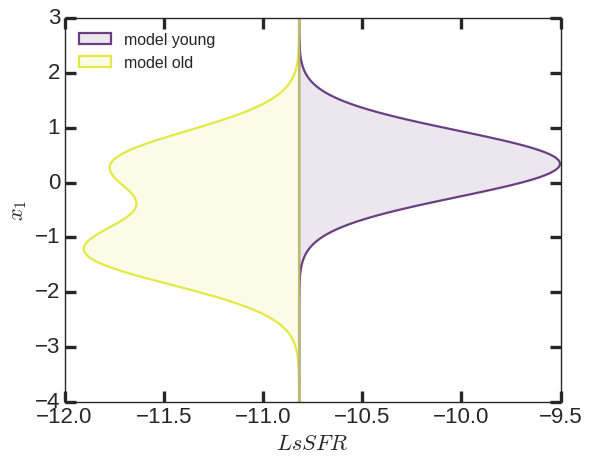

In [13]:
reload(stretchevol)

evol3G2M1S = stretchevol.Evol3G2M1S()
evol3G2M1S.set_data(dataz_all, datax_all, datax_err_all)

evol3G2M1S.minimize(p_l.value, a = snf_a, mu_2 = snf_mu_2,
                               mu_1 = snf_mu_1, sigma_1 = snf_sigma_1)

evol3G2M1S.plotter()

## Utilisation du _mock_ sur large bande de redshifts

In [28]:
evol3G2M1S.param['sigma_2'] = evol3G2M1S.param['sigma_1']

def get_stretch_sample(redshift, npoints, shuffle=True):
    mock = stretchevol.MockEvol()
    mock.set_values(evol3G2M1S.param)
    mock.set_data(redshift, npoints)
    mock.solver()
    mockx = np.concatenate((mock.x1_o,mock.x1_y))
    if shuffle:
        np.random.shuffle(mockx)
    return mockx

In [29]:
zz = np.linspace(0, 2.65, 200)
x1_z = np.asarray([get_stretch_sample(z_, 100000) for z_ in zz])

x_mean = np.mean(x1_z, axis=1)

## EvolNR 1S Fixed

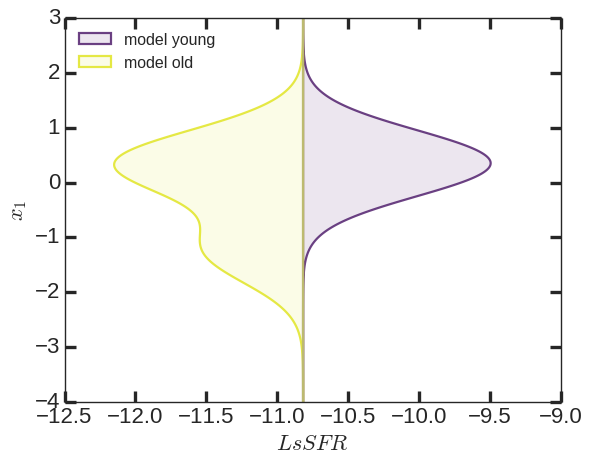

In [137]:
reload(stretchevol)

evol3G2M1SF = stretchevol.Evol3G2M1SF()
evol3G2M1SF.set_data(dataz_all, datax_all, datax_err_all)

evol3G2M1SF.minimize(p_l.value, a = snf_a, mu_2 = snf_mu_2,
                                mu_1 = snf_mu_1, sigma_1 = snf_sigma_1)

evol3G2M1SF.plotter()

## EvolNR 1S SNF

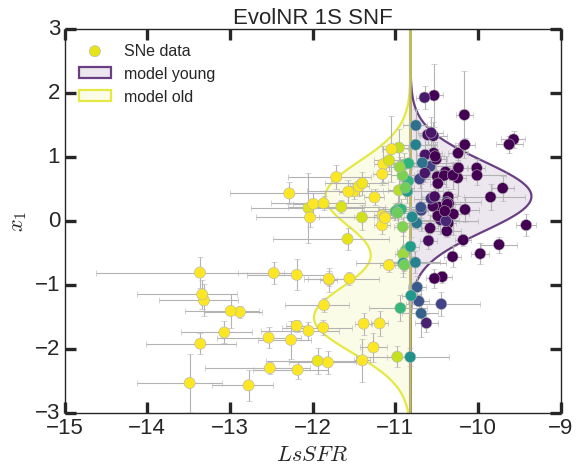

In [66]:
reload(stretchevol)

evol3G2M1SSNF = stretchevol.Evol3G2M1SSNF()
evol3G2M1SSNF.set_lssfr(d_snf['salt2.X1'], d_snf['salt2.X1.err'],
                        d_snf['lssfr'], d_snf['lssfr.err_down'], d_snf['lssfr.err_up'],
                        d_snf['p(prompt)'])

evol3G2M1SSNF.minimize(p_l.value)

evol3G2M1SSNF.plotter('EvolNR 1S SNF')

## EvolNR 2S

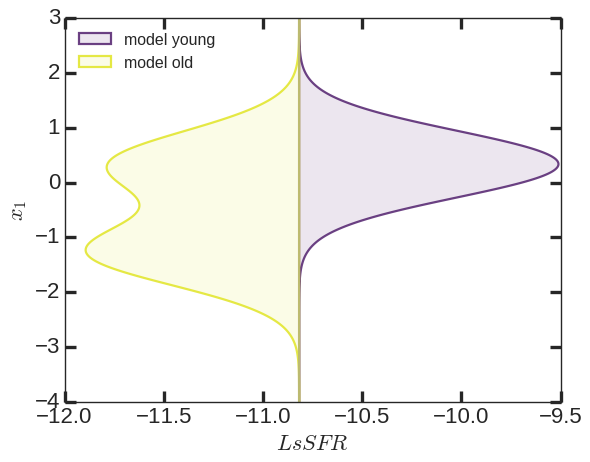

In [178]:
reload(stretchevol)

evol3G2M2S = stretchevol.Evol3G2M2S()
evol3G2M2S.set_data(dataz_all, datax_all, datax_err_all)

evol3G2M2S.minimize(p_l.value)

evol3G2M2S.plotter()

## EvolNR 2S Fixed

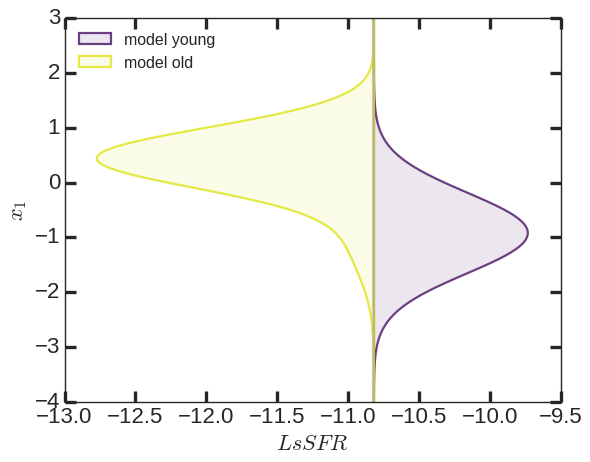

In [67]:
reload(stretchevol)

evol3G2M2SF = stretchevol.Evol3G2M2SF()
evol3G2M2SF.set_data(dataz_all, datax_all, datax_err_all)

evol3G2M2SF.minimize(p_l.value)

evol3G2M2SF.plotter()

## EvolNR 3G 3M 3S

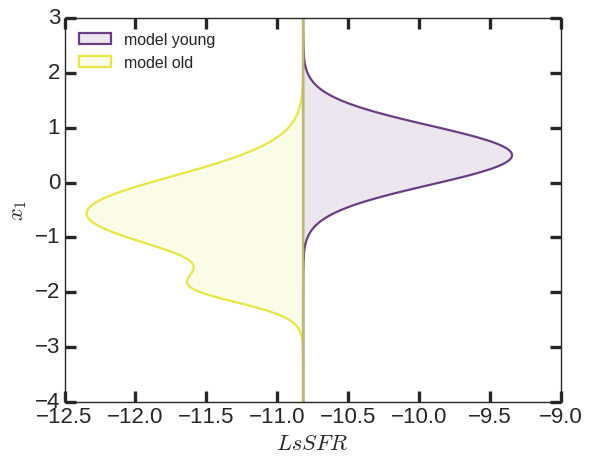

In [51]:
reload(stretchevol)

evol3G3M3S = stretchevol.Evol3G3M3S()
evol3G3M3S.set_data(dataz_all, datax_all, datax_err_all)

evol3G3M3S.minimize(p_l.value)

evol3G3M3S.plotter()

## Get proba

In [9]:
def get_proba(model):
    return np.exp((evol3G2M1S.get_aicc() - model.get_aicc())/2)

## Affichage résultats

In [14]:
print('NR 2G1S logL = ', evol3G3M3S.get_logl())
print('NR 2G1S BIC = ',  evol3G3M3S.get_bic())
print('NR 2G1S AICc = ', evol3G3M3S.get_aicc())
print('NR 2G1S prob = ', get_proba(evol3G3M3S))

NR 2G1S logL =  1812.2484479278153
NR 2G1S BIC =  1857.9951368249108
NR 2G1S AICc =  1826.4129119513102
NR 2G1S prob =  0.16358420856977798
